# Customized models and datasets for CV

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HanXudong/fairlib/blob/main/tutorial/colored_MNIST.ipynb)

In this tutorial we will:
- Show how to add a model for image classification
- Show how to add a dataloader with image preprocessing

We will be using the colored MNIST dataset, please see the [origianl](https://colab.research.google.com/github/reiinakano/invariant-risk-minimization/blob/master/invariant_risk_minimization_colored_mnist.ipynb#scrollTo=knP-xNzavgAb&uniqifier=1) demo for more details.

## Installation

Again, the first step will be installing our libarary

In [1]:
!pip install fairlib

     |████████████████████████████████| 61 kB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 14.8 MB/s 
     |████████████████████████████████| 256 kB 64.7 MB/s 
     |████████████████████████████████| 77 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 6.5 MB 48.3 MB/s 
     |████████████████████████████████| 895 kB 47.9 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import fairlib

In [3]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [4]:
def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([
            arr,
            np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([
            np.zeros((h, w, 1), dtype=dtype),
            arr,
            np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr

In [5]:
root = "./data"

In [6]:
train_mnist = datasets.mnist.MNIST(root=root, train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
len(train_mnist)

60000

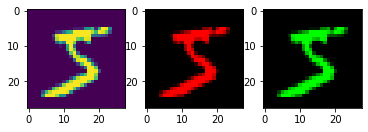

In [8]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(train_mnist[0][0]) # Original
ax[1].imshow(color_grayscale_arr(np.array(train_mnist[0][0]))) # Red
ax[2].imshow(color_grayscale_arr(np.array(train_mnist[0][0]), False)) # Green

In [9]:
test_mnist = datasets.mnist.MNIST(root=root, train=False, download=True)

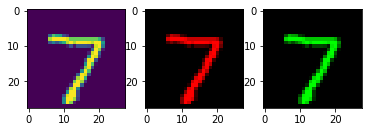

In [10]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(test_mnist[0][0]) # Original
ax[1].imshow(color_grayscale_arr(np.array(test_mnist[0][0]))) # Red
ax[2].imshow(color_grayscale_arr(np.array(test_mnist[0][0]), False)) # Green

In [11]:
def process_colored_MNIST(loaded_data, ratio=0.2):
    im_list, target_class, protected_class = [], [], []
    # Iterate over all images
    for idx, (im, label) in enumerate(loaded_data):
        if idx % 5000 == 0:
            print(f'Converting image {idx}/{len(loaded_data)}')
        im_array = np.array(im)

        # Assign a binary label y to the image based on the digit
        if label < 5:
            red_prob = ratio
        else:
            red_prob = 1-ratio
        
        color_red = (np.random.uniform() < red_prob)

        colored_array = color_grayscale_arr(im_array, red=color_red)

        im_list.append(Image.fromarray(colored_array))
        target_class.append(int(label))
        protected_class.append(int(color_red))
    
    return (im_list, target_class, protected_class)


In [12]:
num_train = len(train_mnist)
indices = list(range(num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[10000:], indices[:10000]

In [13]:
colored_MNIST_train = process_colored_MNIST(torch.utils.data.Subset(train_mnist, train_idx), ratio = 0.8)
colored_MNIST_dev = process_colored_MNIST(torch.utils.data.Subset(train_mnist, valid_idx), ratio = 0.5)
colored_MNIST_test = process_colored_MNIST(test_mnist, ratio = 0.5)

Converting image 0/50000
Converting image 5000/50000
Converting image 10000/50000
Converting image 15000/50000
Converting image 20000/50000
Converting image 25000/50000
Converting image 30000/50000
Converting image 35000/50000
Converting image 40000/50000
Converting image 45000/50000
Converting image 0/10000
Converting image 5000/10000
Converting image 0/10000
Converting image 5000/10000


In [14]:
torch.save(colored_MNIST_train, os.path.join("./data", "colored_MNIST_train.pt"))
torch.save(colored_MNIST_dev, os.path.join("./data", "colored_MNIST_dev.pt"))
torch.save(colored_MNIST_test, os.path.join("./data", "colored_MNIST_test.pt"))

In [15]:
from fairlib import networks, BaseOptions, dataloaders

In [16]:
Shared_options = {
    # The name of the dataset, correponding dataloader will be used,
    "dataset":  "MNIST",

    # Specifiy the path to the input data
    "data_dir": "./data",

    # Device for computing, -1 is the cpu
    "device_id": -1,

    # The default path for saving experimental results
    "results_dir":  r"results",

    # The same as the dataset
    "project_dir":  r"dev",

    # We will focusing on TPR GAP, implying the Equalized Odds for binay classification.
    "GAP_metric_name":  "TPR_GAP",

    # The overall performance will be measured as accuracy
    "Performance_metric_name":  "accuracy",

    # Model selections are based on DTO
    "selection_criterion":  "DTO",

    # Default dirs for saving checkpoints
    "checkpoint_dir":   "models",
    "checkpoint_name":  "checkpoint_epoch",


    "n_jobs":   1,
}

In [17]:
class ConvNet(networks.utils.BaseModel):

    def __init__(self, args):
        super(ConvNet, self).__init__()
        self.args = args
        
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)

        self.classifier = networks.classifier.MLP(args)

        self.init_for_training()

    def forward(self, input_data, group_label = None):
        x = input_data
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)

        return self.classifier(x, group_label)
    
    def hidden(self, input_data, group_label = None):
        x = input_data
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)

        return self.classifier.hidden(x, group_label)

In [18]:
args = {
    "dataset":Shared_options["dataset"], 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Give a name to the exp, which will be used in the path
    "exp_id":"vanilla",

    "emb_size": 4*4*50,
    "num_classes": 10,
    "num_groups": 2,
}

# Init the argument
options = BaseOptions()
state = options.get_state(args=args, silence=True)

INFO:root:Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-9c3335e9-652e-4f42-97e0-8b86721e4921.json']
INFO:root:Logging to ./results/dev/MNIST/vanilla/output.log


2022-04-08 15:15:04 [INFO ]  ======================================== 2022-04-08 15:15:04 ========================================
2022-04-08 15:15:04 [INFO ]  Base directory is ./results/dev/MNIST/vanilla
Not implemented
2022-04-08 15:15:04 [INFO ]  dataloaders need to be initialized!


In [19]:
class CustomizedDataset(dataloaders.utils.BaseDataset):

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))])

    def load_data(self):

        self.data_dir = os.path.join(self.args.data_dir, "colored_MNIST_{}.pt".format(self.split))

        data = torch.load(self.data_dir)

        self.X = [self.transform(_img) for _img in data[0]]
        self.y = data[1]
        self.protected_label = data[2]

In [20]:
customized_train_data = CustomizedDataset(args=state, split="train")
customized_dev_data = CustomizedDataset(args=state, split="dev")
customized_test_data = CustomizedDataset(args=state, split="test")

# DataLoader Parameters
tran_dataloader_params = {
        'batch_size': state.batch_size,
        'shuffle': True,
        'num_workers': state.num_workers}

eval_dataloader_params = {
        'batch_size': state.test_batch_size,
        'shuffle': False,
        'num_workers': state.num_workers}

# init dataloader
customized_training_generator = torch.utils.data.DataLoader(customized_train_data, **tran_dataloader_params)
customized_validation_generator = torch.utils.data.DataLoader(customized_dev_data, **eval_dataloader_params)
customized_test_generator = torch.utils.data.DataLoader(customized_test_data, **eval_dataloader_params)

/usr/local/lib/python3.7/dist-packages/fairlib/src/dataloaders/utils.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.X = np.array(self.X)


Loaded data shapes: (50000,), (50000,), (50000,)
Loaded data shapes: (10000,), (10000,), (10000,)
Loaded data shapes: (10000,), (10000,), (10000,)


In [21]:
model = ConvNet(state)

2022-04-08 15:15:28 [INFO ]  MLP( 
2022-04-08 15:15:28 [INFO ]    (output_layer): Linear(in_features=300, out_features=10, bias=True)
2022-04-08 15:15:28 [INFO ]    (AF): Tanh()
2022-04-08 15:15:28 [INFO ]    (hidden_layers): ModuleList(
2022-04-08 15:15:28 [INFO ]      (0): Linear(in_features=800, out_features=300, bias=True)
2022-04-08 15:15:28 [INFO ]      (1): Tanh()
2022-04-08 15:15:28 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-04-08 15:15:28 [INFO ]      (3): Tanh()
2022-04-08 15:15:28 [INFO ]    )
2022-04-08 15:15:28 [INFO ]    (criterion): CrossEntropyLoss()
2022-04-08 15:15:28 [INFO ]  )
2022-04-08 15:15:28 [INFO ]  Total number of parameters: 333610 

2022-04-08 15:15:28 [INFO ]  ConvNet( 
2022-04-08 15:15:28 [INFO ]    (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
2022-04-08 15:15:28 [INFO ]    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
2022-04-08 15:15:28 [INFO ]    (classifier): MLP(
2022-04-08 15:15:28 [INFO ]  

In [22]:
model.train_self(
    train_generator = customized_training_generator,
    dev_generator = customized_validation_generator,
    test_generator = customized_test_generator,
)

2022-04-08 15:15:31 [INFO ]  Epoch:    0 [      0/  50000 ( 0%)]	Loss: 2.3092	 Data Time: 0.02s	Train Time: 1.06s
2022-04-08 15:16:09 [INFO ]  Evaluation at Epoch 0
2022-04-08 15:16:09 [INFO ]  Validation accuracy: 95.66	macro_fscore: 95.62	micro_fscore: 95.66	TPR_GAP: 4.20	FPR_GAP: 0.42	PPR_GAP: 0.89	
2022-04-08 15:16:09 [INFO ]  Test accuracy: 95.89	macro_fscore: 95.86	micro_fscore: 95.89	TPR_GAP: 4.93	FPR_GAP: 0.43	PPR_GAP: 1.01	
2022-04-08 15:16:10 [INFO ]  Epoch:    1 [      0/  50000 ( 0%)]	Loss: 0.1109	 Data Time: 0.01s	Train Time: 0.64s
2022-04-08 15:16:48 [INFO ]  Evaluation at Epoch 1
2022-04-08 15:16:48 [INFO ]  Validation accuracy: 97.50	macro_fscore: 97.49	micro_fscore: 97.50	TPR_GAP: 2.36	FPR_GAP: 0.29	PPR_GAP: 0.70	
2022-04-08 15:16:48 [INFO ]  Test accuracy: 97.70	macro_fscore: 97.70	micro_fscore: 97.70	TPR_GAP: 3.01	FPR_GAP: 0.35	PPR_GAP: 0.75	
2022-04-08 15:16:48 [INFO ]  Epoch:    2 [      0/  50000 ( 0%)]	Loss: 0.0479	 Data Time: 0.01s	Train Time: 0.63s
2022-04-08 1

In [23]:
debiasing_args = {
    "dataset":Shared_options["dataset"], 
    "data_dir":Shared_options["data_dir"],
    "device_id":Shared_options["device_id"],

    # Give a name to the exp, which will be used in the path
    "exp_id":"BT_Adv",

    "emb_size": 4*4*50,
    "num_classes": 10,
    "num_groups": 2,

    # Perform adversarial training if True
    "adv_debiasing":True,

    # Specify the hyperparameters for Balanced Training
    "BT":"Resampling",
    "BTObj":"EO",
}

# Init the argument
debias_options = BaseOptions()
debias_state = debias_options.get_state(args=debiasing_args, silence=True)

customized_train_data = CustomizedDataset(args=debias_state, split="train")
customized_dev_data = CustomizedDataset(args=debias_state, split="dev")
customized_test_data = CustomizedDataset(args=debias_state, split="test")

# DataLoader Parameters
tran_dataloader_params = {
        'batch_size': state.batch_size,
        'shuffle': True,
        'num_workers': state.num_workers}

eval_dataloader_params = {
        'batch_size': state.test_batch_size,
        'shuffle': False,
        'num_workers': state.num_workers}

# init dataloader
customized_training_generator = torch.utils.data.DataLoader(customized_train_data, **tran_dataloader_params)
customized_validation_generator = torch.utils.data.DataLoader(customized_dev_data, **eval_dataloader_params)
customized_test_generator = torch.utils.data.DataLoader(customized_test_data, **eval_dataloader_params)

debias_model = ConvNet(debias_state)

2022-04-08 15:25:37 [INFO ]  Unexpected args: ['-f', '/root/.local/share/jupyter/runtime/kernel-9c3335e9-652e-4f42-97e0-8b86721e4921.json']
2022-04-08 15:25:37 [INFO ]  Logging to ./results/dev/MNIST/BT_Adv/output.log
2022-04-08 15:25:37 [INFO ]  ======================================== 2022-04-08 15:25:37 ========================================
2022-04-08 15:25:37 [INFO ]  Base directory is ./results/dev/MNIST/BT_Adv
Not implemented
2022-04-08 15:25:37 [INFO ]  dataloaders need to be initialized!
2022-04-08 15:25:37 [INFO ]  SubDiscriminator( 
2022-04-08 15:25:37 [INFO ]    (grad_rev): GradientReversal()
2022-04-08 15:25:37 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-04-08 15:25:37 [INFO ]    (AF): ReLU()
2022-04-08 15:25:37 [INFO ]    (hidden_layers): ModuleList(
2022-04-08 15:25:37 [INFO ]      (0): Linear(in_features=300, out_features=300, bias=True)
2022-04-08 15:25:37 [INFO ]      (1): ReLU()
2022-04-08 15:25:37 [INFO ]      (2): Linear(in_

/usr/local/lib/python3.7/dist-packages/fairlib/src/dataloaders/utils.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.X = np.array(self.X)
/usr/local/lib/python3.7/dist-packages/fairlib/src/dataloaders/utils.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.X = np.array(X)


Loaded data shapes: (20018,), (20018,), (20018,)
Loaded data shapes: (9794,), (9794,), (9794,)
Loaded data shapes: (9798,), (9798,), (9798,)
2022-04-08 15:25:51 [INFO ]  MLP( 
2022-04-08 15:25:51 [INFO ]    (output_layer): Linear(in_features=300, out_features=10, bias=True)
2022-04-08 15:25:51 [INFO ]    (AF): Tanh()
2022-04-08 15:25:51 [INFO ]    (hidden_layers): ModuleList(
2022-04-08 15:25:51 [INFO ]      (0): Linear(in_features=800, out_features=300, bias=True)
2022-04-08 15:25:51 [INFO ]      (1): Tanh()
2022-04-08 15:25:51 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-04-08 15:25:51 [INFO ]      (3): Tanh()
2022-04-08 15:25:51 [INFO ]    )
2022-04-08 15:25:51 [INFO ]    (criterion): CrossEntropyLoss()
2022-04-08 15:25:51 [INFO ]  )
2022-04-08 15:25:51 [INFO ]  Total number of parameters: 333610 

2022-04-08 15:25:51 [INFO ]  ConvNet( 
2022-04-08 15:25:51 [INFO ]    (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
2022-04-08 15:25:51 [INFO ] 

In [24]:
debias_model.train_self(
    train_generator = customized_training_generator,
    dev_generator = customized_validation_generator,
    test_generator = customized_test_generator,
)

2022-04-08 15:26:01 [INFO ]  Epoch:    0 [      0/  20018 ( 0%)]	Loss: 1.6324	 Data Time: 0.02s	Train Time: 2.12s
2022-04-08 15:26:40 [INFO ]  Evaluation at Epoch 0
2022-04-08 15:26:40 [INFO ]  Validation accuracy: 91.53	macro_fscore: 91.46	micro_fscore: 91.53	TPR_GAP: 5.13	FPR_GAP: 0.75	PPR_GAP: 1.08	
2022-04-08 15:26:40 [INFO ]  Test accuracy: 92.26	macro_fscore: 92.18	micro_fscore: 92.26	TPR_GAP: 4.50	FPR_GAP: 0.50	PPR_GAP: 0.83	
2022-04-08 15:26:42 [INFO ]  Epoch:    1 [      0/  20018 ( 0%)]	Loss: -0.4085	 Data Time: 0.01s	Train Time: 1.82s
2022-04-08 15:27:21 [INFO ]  Evaluation at Epoch 1
2022-04-08 15:27:21 [INFO ]  Validation accuracy: 94.82	macro_fscore: 94.77	micro_fscore: 94.82	TPR_GAP: 4.61	FPR_GAP: 0.52	PPR_GAP: 0.69	
2022-04-08 15:27:21 [INFO ]  Test accuracy: 95.24	macro_fscore: 95.18	micro_fscore: 95.24	TPR_GAP: 3.36	FPR_GAP: 0.49	PPR_GAP: 0.63	
2022-04-08 15:27:23 [INFO ]  Epoch:    2 [      0/  20018 ( 0%)]	Loss: -0.5775	 Data Time: 0.01s	Train Time: 1.79s
2022-04-08